# Episode 40. Variational Autoencoder (VAE)

## Import Libraries

In [40]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import regularizers

## Load Data

In [41]:
# Keras gives 28x28 image data; value range 0-255; and splits train /test data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Rescale Data (value range 0-255 to range 0-1)

In [42]:
# For neural network input: scale 0-1; reshae 28x28 image to 1D (784,)
x_train = x_train.reshape(60000, 784) / 255
x_test = x_test.reshape(10000, 784) / 255

## Variational Autoencoder Network

### (1) Define Network Parameters

In [43]:
# defining the key parameters
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [44]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

### (2) Sampling Random Number

In [45]:
# sampling from mean and sd in VAE
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### (3) Defining Encoder

In [46]:
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

### (4) Define Decoder

In [47]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


### (5) Define Variational Autoencoder (VAE)

In [48]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


### (6) VAE Loss

In [49]:
# Defina VAE Loss Function
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

### (7) Compile VAE

In [52]:
vae.compile(optimizer='adam', loss=vae_loss, metrics=['accuracy'])
vae.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


### (8) Train VAE

In [53]:
history = vae.fit(x_train, x_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    verbose=1).history

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 155us/sample - loss: 161.8850 - acc: 0.0160 - val_loss: 161.7355 - val_acc: 0.0138
Epoch 2/50
60000/60000 [==============================] - 9s 149us/sample - loss: 160.7349 - acc: 0.0154 - val_loss: 160.6146 - val_acc: 0.0138
Epoch 3/50
60000/60000 [==============================] - 9s 153us/sample - loss: 159.8680 - acc: 0.0143 - val_loss: 159.8566 - val_acc: 0.0129
Epoch 4/50
60000/60000 [==============================] - 9s 152us/sample - loss: 159.1545 - acc: 0.0142 - val_loss: 159.3210 - val_acc: 0.0128
Epoch 5/50
60000/60000 [==============================] - 9s 151us/sample - loss: 158.5456 - acc: 0.0124 - val_loss: 158.7383 - val_acc: 0.0139
Epoch 6/50
60000/60000 [==============================] - 9s 150us/sample - loss: 157.9790 - acc: 0.0125 - val_loss: 158.4298 - val_acc: 0.0143
Epoch 7/50
60000/60000 [==============================] - 9s 149us/sample - loss: 157.

## Encoder Output: 2D Latent Space

In [54]:
encoder_out = encoder.predict(x_test)[2]  # encoder output is [z_mean,z_log_var,z]

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [55]:
encoder_out.shape
encoder_out[0:5,:]

array([[ 0.829464  ,  0.30952767],
       [-0.57658976, -0.9164229 ],
       [ 2.2170393 ,  1.5773221 ],
       [-2.3310754 , -0.18788849],
       [ 1.2327392 , -0.6019284 ]], dtype=float32)

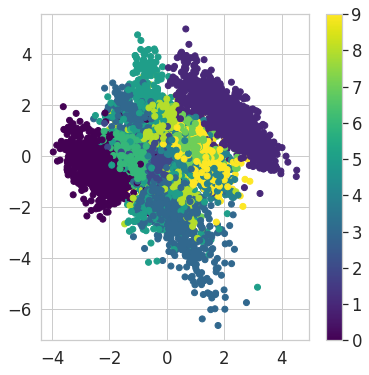

In [56]:
# display a 2D plot of the digit classes in the latent space
plt.figure(figsize=(6, 6))
plt.scatter(encoder_out[:,0], encoder_out[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

## Reconstruction: test data

In [57]:
vae_out = vae.predict(x_test)        # reconstruction

## Reconstruction Error: test data

In [58]:
err2 = np.sum((x_test-vae_out)**2)/vae_out.shape[0]/vae_out.shape[1]
print('VAE reconstruction error: ' + str(round(err2,3)));

VAE reconstruction error: 0.042


## Plot Original (x) & Reconstructed (xhat) Image

In [59]:
# select image
idx = 0
x_plot = x_test[idx,:]
xhat_plot = vae_out[idx,:]
# corresponding label
y_plot = y_test[idx]
# restore original value (from standardized 0-1 to original value 0-255)
x_plot = x_plot*255
xhat_plot = xhat_plot*255
# check label & x dimension
print(y_plot,x_plot.shape)

7 (784,)


In [60]:
# reshape into 2D image data (784 to 28 x 28)
x_img = x_plot.reshape((28,28))
xhat_img = xhat_plot.reshape((28,28))

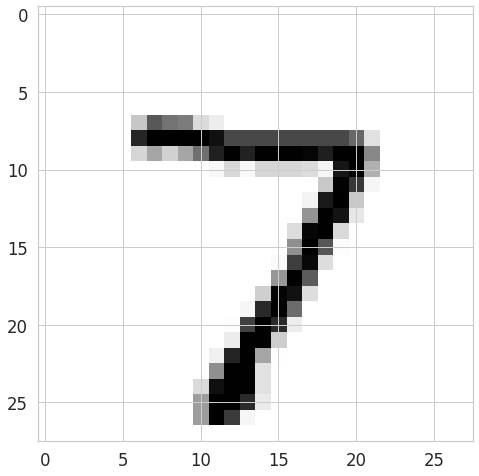

In [61]:
# plot 2D image: Original
plt.imshow(x_img,cmap='Greys',interpolation='None')

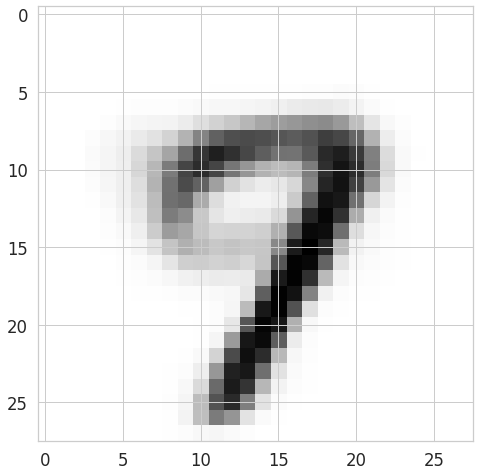

In [62]:
# plot 2D image: Reconstructed
plt.imshow(xhat_img,cmap='Greys',interpolation='None')